In [10]:
from typing import Literal
from datetime import datetime
import pandas as pd
import re

In [ ]:
# Задание 1.
# Реализуйте базовый класс Account, который моделирует поведение
# банковского счёта. Этот класс должен не только выполнять базовые
# операции, но и вести детальный учёт всех действий, а также предоставлять
# аналитику по истории операций.

# Задание 2.
# Реализуйте валидацию на отрицательные суммы и корректность имени владельца.
# Реализуйте метод для анализа истории транзакций по размеру и дате: метод должен выводить последние n крупных операций.


class Transaction:
    def __init__(self,
                 operation_type: Literal['deposit', 'interest', 'withdraw'],
                 operation_total: float,
                 timestamp: datetime,
                 resulting_balance: float,
                 status: Literal['success', 'fail']
    ):
        """
        Класс Transaction содержит информацию об операции с банковским счетом:
        * operation_type - тип операции, один из 'deposit', 'interest' или 'withdraw'
        * operation_total - сумма операции
        * timestamp - временная метка операции
        * resulting_balance - баланс банковского счета после выполнения операции
        * status - статус операции, 'success' или 'fail'
        """
        if operation_type not in ['deposit', 'interest', 'withdraw']:
            raise ValueError(f"Значение operation_type = `{operation_type}` не поддерживается")
        if status not in ['success', 'fail']:
            raise ValueError(f"Значение status = `{status}` не поддерживается")
        if operation_total < 0:
            raise ValueError("Отрицательная сумма операции")
        self.operation_type = operation_type
        self.operation_total = operation_total
        self.timestamp = timestamp
        self.resulting_balance = resulting_balance
        self.status = status

    def __dict__(self):
        return {
            'operation_type': self.operation_type,
            'operation_total': self.operation_total,
            'timestamp': self.timestamp,
            'resulting_balance': self.resulting_balance,
            'status': self.status
        }


class Account:

    # Счетчик созданных банковских счетов
    _account_counter = 1000

    def _set_initial_balance(self, balance: float = 0):
        """
        Инициализация баланса банковского счета
        """
        if balance < 0:
            raise ValueError("Отрицательная сумма операции")
        if len(self.__operations_history) > 0:
            raise ValueError("По счету уже были проведены операции - невозможно инициализировать баланс")
        self.__balance = balance

    def __init__(self, account_holder: str, balance: float = 0):
        """
        Класс Account содержит информацию о банковском счете:
        * номер счета
        * владелец
        * баланс
        * история операций
        """
        if not re.match(r'^[A-ZА-Я][a-zа-я]* [A-ZА-Я][a-zа-я]*$', account_holder):
            raise ValueError("Неверный формат имени владельца счета account_holder")

        # Задаем номер счета и увеличиваем счетчик созданных
        self.account_number = f"ACC-{Account._account_counter}"
        Account._account_counter += 1

        self.holder = account_holder
        self.__operations_history = list()
        self._set_initial_balance(balance)

    def deposit(self,
                amount: float,
                timestamp: datetime = datetime.now(),
                failed: bool = False,
                operation_type: Literal['deposit', 'interest'] = 'deposit'
    ):
        """
        Метод для увеличения баланса банковского счета.
        Поддерживается два вида операции - депозит и начисление процентов
        """
        if amount < 0:
            raise ValueError("Отрицательная сумма операции")
        if operation_type not in ['deposit', 'interest']:
            raise ValueError(f"Значение operation_type = `{operation_type}` не поддерживается")

        self.__balance += amount
        self.__operations_history.append(
            Transaction(operation_type,
                        amount,
                        timestamp,
                        self.__balance,
                        'success' if not failed else 'fail')
        )

    def withdraw(self,
                 amount: float,
                 timestamp: datetime = datetime.now(),
                 failed: bool = False
    ):
        """
        Метод для списания средств с банковского счета.

        При недостатке средств или передаче флага failed = True списания не происходит,
        ошибочная операция записыватся в историю
        """
        if amount < 0:
            raise ValueError("Отрицательная сумма операции")
        if amount > self.__balance or failed:
            self.__operations_history.append(
                Transaction('withdraw',
                            amount,
                            timestamp,
                            self.__balance,
                            'fail')
            )
        else:
            self.__balance -= amount
            self.__operations_history.append(
                Transaction('withdraw',
                            amount,
                            timestamp,
                            self.__balance,
                            'success')
            )

    def get_balance(self):
        """Метод получения текущего баланса счета"""
        return self.__balance

    def get_history(self):
        """Метод получения истории операций по счету"""
        return tuple(vars(x)() for x in self.__operations_history)

    def plot_history(self):
        """Метод создания графика истории операций по счету"""
        df = pd.DataFrame(self.get_history())
        plot = df.plot(kind='line',
                       x='timestamp',
                       y='resulting_balance',
                       xlabel='Время операции',
                       ylabel='Баланс',
                       title=f'Динамика баланса на счете {self.account_number} клиента {self.holder}',
                       legend=False,
                       ylim=[0, None],
                       drawstyle='steps-post'
        )
        plot.grid()
        return plot

    def analyse_history(self, n: int):
        """Метод анализа последних n крупных операций по счету"""
        df = pd.DataFrame(self.get_history())
        df = df[df['status'] == 'success']
        df = df[df['operation_total'] > df['operation_total'].quantile(0.5)]
        df = df.sort_values(by='timestamp', ascending=False)
        return df.head(n).reset_index(drop=True)


In [ ]:
# Проверка методов класса Account
c = Account('Andrew Smith')
b = Account('Kate Anderson')
a = Account('Vsevolod Kasyan')

a.deposit(100, datetime.fromisoformat('2025-10-05 09:43'))
a.deposit(50, datetime.fromisoformat('2025-10-20 09:22'))
a.withdraw(160, datetime.fromisoformat('2025-10-22 14:10'))
a.deposit(20, datetime.fromisoformat('2025-10-25'))
a.withdraw(160, datetime.fromisoformat('2025-11-01'))
a.deposit(200, datetime.fromisoformat('2025-11-03'))
a.deposit(4, datetime.fromisoformat('2025-11-04 13:04'))
a.withdraw(38, datetime.fromisoformat('2025-11-05 18:47'))
a.deposit(25, datetime.fromisoformat('2025-11-06 19:33'))
a.withdraw(140, datetime.fromisoformat('2025-11-07 18:47'))
a.deposit(450, datetime.fromisoformat('2025-11-10 10:00'))
a.withdraw(362, datetime.fromisoformat('2025-11-11 18:47'))

a.get_history()

({'operation_type': 'deposit',
  'operation_total': 100,
  'timestamp': datetime.datetime(2025, 10, 5, 9, 43),
  'resulting_balance': 100,
  'status': 'success'},
 {'operation_type': 'deposit',
  'operation_total': 50,
  'timestamp': datetime.datetime(2025, 10, 20, 9, 22),
  'resulting_balance': 150,
  'status': 'success'},
 {'operation_type': 'withdraw',
  'operation_total': 160,
  'timestamp': datetime.datetime(2025, 10, 22, 14, 10),
  'resulting_balance': 150,
  'status': 'fail'},
 {'operation_type': 'deposit',
  'operation_total': 20,
  'timestamp': datetime.datetime(2025, 10, 25, 0, 0),
  'resulting_balance': 170,
  'status': 'success'},
 {'operation_type': 'withdraw',
  'operation_total': 160,
  'timestamp': datetime.datetime(2025, 11, 1, 0, 0),
  'resulting_balance': 10,
  'status': 'success'},
 {'operation_type': 'deposit',
  'operation_total': 200,
  'timestamp': datetime.datetime(2025, 11, 3, 0, 0),
  'resulting_balance': 210,
  'status': 'success'},
 {'operation_type': 'depo

<Axes: title={'center': 'Динамика баланса на счете ACC-1002 клиента Vsevolod Kasyan'}, xlabel='Время операции', ylabel='Баланс'>

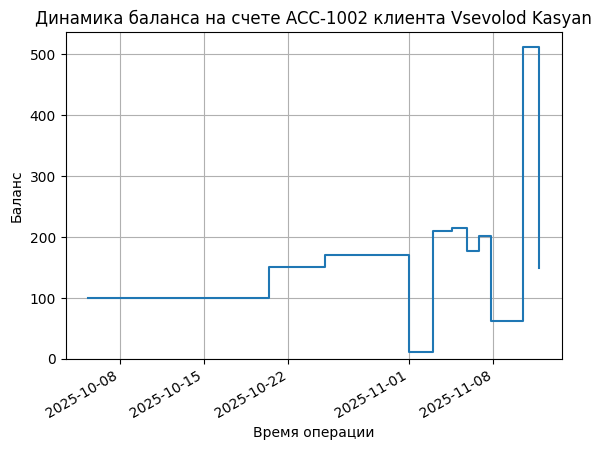

In [23]:
# Проверка создания графика истории операций по счету
a.plot_history()

In [ ]:
# Проверка метода анализа последних n крупных операций по счету
a.analyse_history(3)

,operation_type,operation_total,timestamp,resulting_balance,status
0,withdraw,362,2025-11-11 18:47:00,149,success
1,deposit,450,2025-11-10 10:00:00,511,success
2,withdraw,140,2025-11-07 18:47:00,61,success


In [57]:
# Задание 2.
# Реализуйте два класса CheckingAccount (расчётный счёт) и
# SavingsAccount (сберегательный счёт), которые отражают абстракцию
# базового поведения банковских аккаунтов:
# * наследуются от базового класса Account;
# * хранят атрибут класса account_type.
# Класс SavingsAccount (сберегательный счёт) дополнительно должен
# реализовывать метод расчёта процентов на остаток
# apply_interest(self, rate) (например, 7% на остаток).
# 3. Класс SavingsAccount (сберегательный счёт) позволяет снимать
# деньги только до определенного порога баланса: нельзя снять
# больше 50% от баланса. Переопределите метод снятия со счёта

# Задание 3. Реализуйте для классов аккаунтов CheckingAccount (расчётный счёт) и
# SavingsAccount (сберегательный счёт) два метода:
# * Метод загрузки истории в аккаунт из файла с транзакциями (файл
# транзакций общий для всех аккаунтов, необходимо учесть
# фильтрацию загружаемых значений).
# * Метод clean_history(), который ищет ошибки в данных перед записью
# транзакций в историю (опечатки, отрицательные суммы, неверные
# даты). Обратите внимание, что для SavingsAccount (сберегательный
# счёт) доступно три типа операции (deposit, withdraw и interest), в то
# время как для CheckingAccount (расчётный счёт) доступны только два
# типа операции (deposit, withdraw). Все данные с ошибками считаем
# невалидными и не записываем в историю операций.
# * После загрузки истории операций в аккаунт, баланс счёта должен
# обновиться.

class CheckingAccount(Account):
    account_type = 'Расчётный счёт'
    __operation_types = ['deposit', 'withdraw']

    def __init__(self, *args, **kwargs):
        """
        Класс CheckingAccount содержит информацию о расчетном банковском счете:
        * номер счета
        * владелец
        * баланс
        * история операций
        
        Класс имеет метод clean_history для загрузки истории операций
        """
        super().__init__(*args, **kwargs)

    def clean_history(self, source: str, account_number: str):
        """Метод загрузки истории операций по расчетному счету из файла с транзакциями, игнорируя ошибочные записи"""
        # Чтение и очистка входных данных
        df = pd.read_csv(source)
        df = df[df['account_number'] == account_number]
        df['date'] = pd.to_datetime(
            df.date, format='mixed', errors='coerce', dayfirst=True)
        df = df[
            df.operation.isin(CheckingAccount.__operation_types)
            & df.status.isin(['success', 'fail'])
            & (df.amount > 0)
        ].dropna().sort_values('date', ascending=True)

        # Определение изначального баланса счета по первой операции
        self._set_initial_balance(
            df.iloc[0]['balance_after']
            + (-1 if df.iloc[0]['status'] == 'success' else 0) * df.iloc[0]['amount'] * (-1 if df.iloc[0]['operation'] == 'withdraw' else 1)
        )
        
        # Загрузка истории операций вызовами соответствующих методов
        for row in df.itertuples():
            if row.operation == 'deposit':
                self.deposit(row.amount, row.date, row.status == 'fail')
            elif row.operation == 'withdraw':
                self.withdraw(row.amount, row.date, row.status == 'fail')


class SavingsAccount(Account):
    account_type = 'Сберегательный счёт'
    __operation_types = ['deposit', 'withdraw', 'interest']

    def __init__(self, *args, **kwargs):
        """
        Класс SavingsAccount содержит информацию о накопительном банковском счете:
        * номер счета
        * владелец
        * баланс
        * история операций
        
        Класс имеет метод apply_interest для начисления процентов и 
        метод clean_history для загрузки истории операций
        """
        super().__init__(*args, **kwargs)

    def clean_history(self, source: str, account_number: str):
        """Метод загрузки истории операций по накопительному счету из файла с транзакциями, игнорируя ошибочные записи"""
        # Чтение и очистка входных данных
        df = pd.read_csv(source)
        df = df[df['account_number'] == account_number]
        df['date'] = pd.to_datetime(
            df.date, format='mixed', errors='coerce', dayfirst=True)
        df = df[
            df.operation.isin(SavingsAccount.__operation_types)
            & df.status.isin(['success', 'fail'])
            & (df.amount > 0)
        ].dropna().sort_values('date', ascending=True)

        # Определение изначального баланса счета по первой операции
        self._set_initial_balance(
            df.iloc[0]['balance_after']
            + (-1 if df.iloc[0]['status'] == 'success' else 0) * df.iloc[0]['amount'] * (-1 if df.iloc[0]['operation'] == 'withdraw' else 1)
        )
        
        # Загрузка истории операций вызовами соответствующих методов
        for row in df.itertuples():
            if row.operation == 'deposit':
                self.deposit(row.amount, row.date, row.status == 'fail')
            elif row.operation == 'interest':
                self.deposit(row.amount, row.date,
                             row.status == 'fail', 'interest')
            elif row.operation == 'withdraw':
                self.withdraw(row.amount, row.date, row.status == 'fail')

    def apply_interest(self, rate: float):
        """Метод начисления rate процентов по накопительному счету"""
        super().deposit(self.get_balance() * rate / 100, operation_type='interest')

    def withdraw(self, amount: float, timestamp: datetime = datetime.now(), failed: bool = False):
        """
        Метод для списания средств с накопительного счета.

        При попытке снять более 50% остатка средств, недостатке средств
        или передаче флага failed = True списания не происходит,
        ошибочная операция записыватся в историю
        """
        if amount * 2 > self.get_balance():
            super().withdraw(amount, timestamp, failed=True)
        else:
            super().withdraw(amount, timestamp, failed)

Сберегательный счёт


({'operation_type': 'withdraw',
  'operation_total': 160,
  'timestamp': datetime.datetime(2025, 10, 1, 0, 0),
  'resulting_balance': 0,
  'status': 'fail'},
 {'operation_type': 'deposit',
  'operation_total': 200,
  'timestamp': datetime.datetime(2025, 10, 3, 0, 0),
  'resulting_balance': 200,
  'status': 'success'},
 {'operation_type': 'deposit',
  'operation_total': 4,
  'timestamp': datetime.datetime(2025, 10, 4, 13, 4),
  'resulting_balance': 204,
  'status': 'success'},
 {'operation_type': 'withdraw',
  'operation_total': 38,
  'timestamp': datetime.datetime(2025, 10, 5, 18, 47),
  'resulting_balance': 166,
  'status': 'success'},
 {'operation_type': 'deposit',
  'operation_total': 25,
  'timestamp': datetime.datetime(2025, 10, 6, 19, 33),
  'resulting_balance': 191,
  'status': 'success'},
 {'operation_type': 'withdraw',
  'operation_total': 140,
  'timestamp': datetime.datetime(2025, 10, 7, 18, 47),
  'resulting_balance': 191,
  'status': 'fail'},
 {'operation_type': 'deposit',

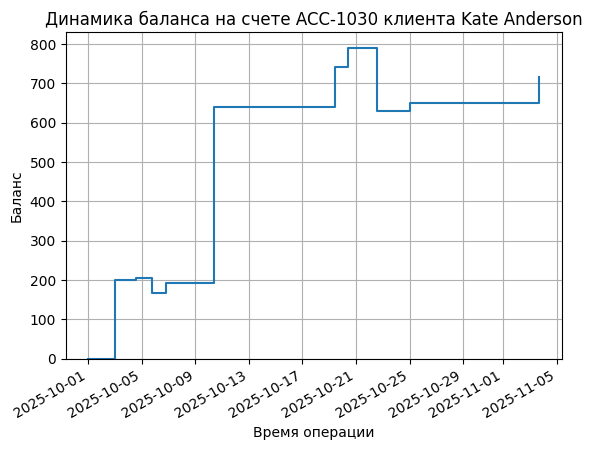

In [49]:
# Проверка методов класса SavingsAccount
a = SavingsAccount('Kate Anderson')

a.withdraw(160, datetime.fromisoformat('2025-10-01'))
a.deposit(200, datetime.fromisoformat('2025-10-03'))
a.deposit(4, datetime.fromisoformat('2025-10-04 13:04'))
a.withdraw(38, datetime.fromisoformat('2025-10-05 18:47'))
a.deposit(25, datetime.fromisoformat('2025-10-06 19:33'))
a.withdraw(140, datetime.fromisoformat('2025-10-07 18:47'))
a.deposit(450, datetime.fromisoformat('2025-10-10 10:00'))
a.withdraw(362, datetime.fromisoformat('2025-10-11 18:47'))
a.deposit(100, datetime.fromisoformat('2025-10-19 09:43'))
a.deposit(50, datetime.fromisoformat('2025-10-20 09:22'))
a.withdraw(160, datetime.fromisoformat('2025-10-22 14:10'))
a.deposit(20, datetime.fromisoformat('2025-10-25'))

a.apply_interest(10)

print(a.account_type)
a.plot_history()
a.get_history()

<Axes: title={'center': 'Динамика баланса на счете ACC-1054 клиента Anna Smith'}, xlabel='Время операции', ylabel='Баланс'>

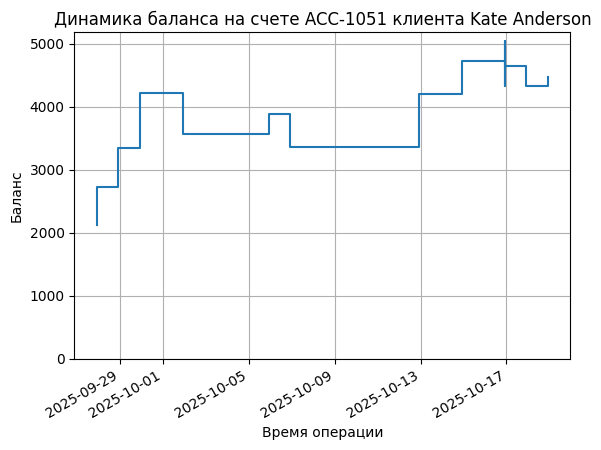

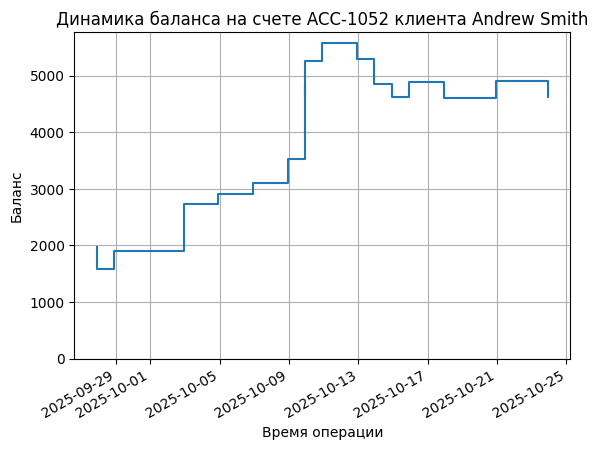

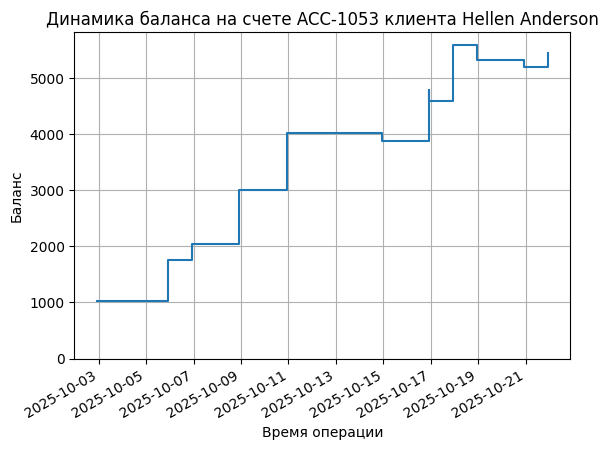

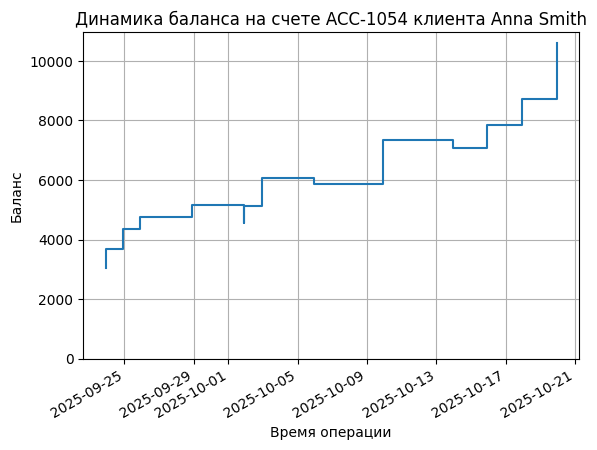

In [58]:
# Проверка методов clean_history классов CheckingAccount и SavingsAccount
a = CheckingAccount('Kate Anderson')
a.clean_history('transactions_dirty.csv', 'ACC-100001')
a.plot_history()

b = SavingsAccount('Andrew Smith')
b.clean_history('transactions_dirty.csv', 'ACC-100002')
b.plot_history()

c = CheckingAccount('Hellen Anderson')
c.clean_history('transactions_dirty.csv', 'ACC-100003')
c.plot_history()

d = SavingsAccount('Anna Smith')
d.clean_history('transactions_dirty.csv', 'ACC-100004')
d.plot_history()